# Anaerobic Digestion Model No. 1 (ADM1) <a class="anchor" id="top"></a>

- **Prepared by:**
    
    - [Ga-Yeong Kim](https://qsdsan.readthedocs.io/en/latest/CONTRIBUTING.html)
    
- **Covered topics:**

    - [1. Introduction](#s1)
    - [2. System Setup](#s2)
    - [3. System Simulation](#s3)
    
To run tutorials in your browser, go to this [Binder page](https://mybinder.org/v2/gh/QSD-Group/QSDsan-env/main?urlpath=git-pull%3Frepo%3Dhttps%253A%252F%252Fgithub.com%252FQSD-group%252FQSDsan%26urlpath%3Dtree%252FQSDsan%252Fdocs%252Fsource%252Ftutorials%26branch%3Dmain).

In [1]:
import qsdsan as qs, exposan
print(f'This tutorial was made with qsdsan v{qs.__version__} and exposan v{exposan.__version__}')

This tutorial was made with qsdsan v1.3.1 and exposan v1.3.1


## 1. Introduction <a class="anchor" id="s1"></a>

Anaerobic Digestion Model No.1 (ADM1) includes multiple steps describing **biochemical** as well as **physicochemical processes**. 

The **biochemical steps** include disintegration from homogeneous particulates to carbohydrates, proteins and lipids; extracellular hydrolysis of these particulate substrates to sugars, amino acids, and long chain fatty acids (LCFA), respectively; acidogenesis from sugars and amino acids to volatile fatty acids (VFAs) and hydrogen; acetogenesis of LCFA and VFAs to acetate; and separate methanogenesis steps from acetate and hydrogen/CO2. 

The **physico-chemical equations** describe ion association and dissociation, and gas-liquid transfer. 

Implemented as a differential and algebraic equation (DAE) set, there are 26 dynamic state concentration variables, and 8 implicit algebraic variables per reactor vessel or element. Implemented as differential equations (DE) only, there are 32 dynamic concentration state variables.

*Water Science and Technology, Vol 45, No 10, pp 65–73*

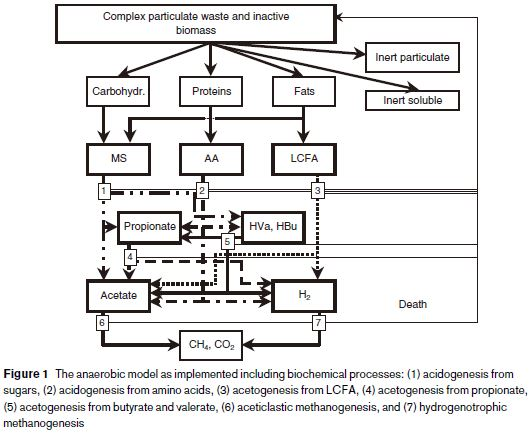

**Note:** You can find validation of the ADM1 system in [EXPOsan](https://github.com/QSD-Group/EXPOsan/tree/main/exposan/adm).

## 2. System Setup <a class="anchor" id="s2"></a>

In [2]:
# Import packages
import numpy as np
from chemicals.elements import molecular_weight as get_mw
from qsdsan import sanunits as su, processes as pc, WasteStream, System
from qsdsan.utils import time_printer

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)        # to ignore Pandas future warning

### 2.1. State variables of ADM1

In [3]:
# Components 
cmps = pc.create_adm1_cmps()           # create state variables for ADM1
cmps.show()                            # 26 components in ADM1 + water

CompiledComponents([S_su, S_aa, S_fa, S_va, S_bu, S_pro, S_ac, S_h2, S_ch4, S_IC, S_IN, S_I, X_c, X_ch, X_pr, X_li, X_su, X_aa, X_fa, X_c4, X_pro, X_ac, X_h2, X_I, S_cat, S_an, H2O])


**S_su**: Monosaccharides, **S_aa**: Amino acids, **S_fa**: Total long-chain fatty acids, **S_va**: Total valerate, **S_bu**: Total butyrate, **S_pro**: Total propionate, **S_ac**: Total acetate, **S_h2**: Hydrogen gas, **S_ch4**: Methane gas, **S_IC**: Inorganic carbon, **S_IN**: Inorganic nitrogen, **S_I**: Soluble inerts, **X_c**: Composites, **X_ch**: Carobohydrates, **X_pr**: Proteins, **X_li**: Lipids, **X_su**: Biomass uptaking sugars, **X_aa**: Biomass uptaking amino acids, **X_fa**: Biomass uptaking long chain fatty acids, **X_c4**: Biomass uptaking c4 fatty acids (valerate and butyrate), **X_pro**: Biomass uptaking propionate, **X_ac**: Biomass uptaking acetate, **X_h2**: Biomass uptaking hydrogen, **X_I**: Particulate inerts, **S_cat**: Other cations, **S_an**: Other anions

### 2.2. The ADM1 `Process`

In [4]:
# Processes
adm1 = pc.ADM1()                       # create ADM1 processes
adm1.show()                            # 22 processes in ADM1

ADM1([disintegration, hydrolysis_carbs, hydrolysis_proteins, hydrolysis_lipids, uptake_sugars, uptake_amino_acids, uptake_LCFA, uptake_valerate, uptake_butyrate, uptake_propionate, uptake_acetate, uptake_h2, decay_Xsu, decay_Xaa, decay_Xfa, decay_Xc4, decay_Xpro, decay_Xac, decay_Xh2, h2_transfer, ch4_transfer, IC_transfer])


### 2.3. Petersen matrix of ADM1

In [5]:
# Petersen stoichiometric matrix
adm1.stoichiometry

,S_su,S_aa,S_fa,S_va,S_bu,...,X_h2,X_I,S_cat,S_an,H2O
disintegration,0,0,0,0,0,...,0,0.2,0,0,0
hydrolysis_carbs,1,0,0,0,0,...,0,0,0,0,0
hydrolysis_proteins,0,1,0,0,0,...,0,0,0,0,0
hydrolysis_lipids,0.05,0,0.95,0,0,...,0,0,0,0,0
uptake_sugars,-1,0,0,0,0.117,...,0,0,0,0,0
uptake_amino_acids,0,-1,0,0.212,0.239,...,0,0,0,0,0
uptake_LCFA,0,0,-1,0,0,...,0,0,0,0,0
uptake_valerate,0,0,0,-1,0,...,0,0,0,0,0
uptake_butyrate,0,0,0,0,-1,...,0,0,0,0,0
uptake_propionate,0,0,0,0,0,...,0,0,0,0,0


**The rate of production or consumption for a state variable**<br>

$a_{ij}$: the stoichiometric coefficient of component $j$ in process $i$ (i.e., value on the $i$th row and $j$th column of the stoichiometry matrix) <br>
$\rho_i$: process $i$'s reaction rate <br>
$r_j$:  the overall production or consumption rate of component $j$<br>
$$r_j  = \sum_i{a_{ij}\cdot\rho_i}$$
In matrix notation, this calculation can be neatly described as
$$\mathbf{r} = \mathbf{A^T} \mathbf{\rho}$$
where $\mathbf{A}$ is the stoichiometry matrix and $\mathbf{\rho}$ is the array of process rates.

### 2.4. Influent & effluent

In [6]:
# Flow rate, temperature, HRT
Q = 170                                             # influent flowrate [m3/d]
Temp = 273.15+35                                    # temperature [K]
HRT = 5                                             # HRT [d]

In [7]:
# WasteStream
inf = WasteStream('Influent', T=Temp)               # influent
eff = WasteStream('Effluent', T=Temp)               # effluent
gas = WasteStream('Biogas')                         # gas

In [8]:
# Set influent concentration
C_mw = get_mw({'C':1})        # molecular weight of carbon
N_mw = get_mw({'N':1})        # molecular weight of nitrogen

default_inf_kwargs = {
    'concentrations': {
        'S_su':0.01,
        'S_aa':1e-3,
        'S_fa':1e-3,
        'S_va':1e-3,
        'S_bu':1e-3,
        'S_pro':1e-3,
        'S_ac':1e-3,
        'S_h2':1e-8,
        'S_ch4':1e-5,
        'S_IC':0.04*C_mw,
        'S_IN':0.01*N_mw,
        'S_I':0.02,
        'X_c':2.0,
        'X_ch':5.0,
        'X_pr':20.0,
        'X_li':5.0,
        'X_aa':1e-2,
        'X_fa':1e-2,
        'X_c4':1e-2,
        'X_pro':1e-2,
        'X_ac':1e-2,
        'X_h2':1e-2,
        'X_I':25,
        'S_cat':0.04,
        'S_an':0.02,
        },
    'units': ('m3/d', 'kg/m3'),
    }                                                           # concentration of each state variable in influent

inf.set_flow_by_concentration(Q, **default_inf_kwargs)          # set influent concentration
inf

WasteStream: Influent
phase: 'l', T: 308.15 K, P: 101325 Pa
flow (g/hr): S_su   70.8
             S_aa   7.08
             S_fa   7.08
             S_va   7.08
             S_bu   7.08
             S_pro  7.08
             S_ac   7.08
             S_h2   7.08e-05
             S_ch4  0.0708
             S_IC   3.4e+03
             S_IN   992
             S_I    142
             X_c    1.42e+04
             X_ch   3.54e+04
             X_pr   1.42e+05
             ...    6.97e+06
 WasteStream-specific properties:
  pH         : 7.0
  Alkalinity : 2.5 mg/L
  COD        : 57096.0 mg/L
  BOD        : 12769.4 mg/L
  TC         : 20596.5 mg/L
  TOC        : 20116.0 mg/L
  TN         : 3683.2 mg/L
  TP         : 489.3 mg/L
  TK         : 9.8 mg/L
 Component concentrations (mg/L):
  S_su   10.0
  S_aa   1.0
  S_fa   1.0
  S_va   1.0
  S_bu   1.0
  S_pro  1.0
  S_ac   1.0
  S_h2   0.0
  S_ch4  0.0
  S_IC   480.4
  S_IN   140.1
  S_I    20.0
  X_c    2000.0
  X_ch   5000.0
  X_pr   20000.0
  ...


### 2.5. Reactor

In [9]:
# SanUnit
AD = su.AnaerobicCSTR('AD', ins=inf, outs=(gas, eff), model=adm1, V_liq=Q*HRT, V_gas=Q*HRT*0.1, T=Temp)

**su.AnaerobicCSTR**(
    ID='',
    ins=None,
    outs=(),
    thermo=None,
    init_with='WasteStream',
    V_liq=3400,
    V_gas=300,
    model=None,
    T=308.15,
    headspace_P=1.013,
    external_P=1.013,
    pipe_resistance=50000.0,
    fixed_headspace_P=False,
    retain_cmps=(),
    fraction_retain=0.95,
    isdynamic=True,
    exogenous_vars=(),
    **kwargs,
)

**Parameters**<br>
*ins* : :class:`WasteStream`,
    Influent to the reactor.<br>
*outs* : Iterable,
    Biogas and treated effluent(s).<br>
*V_liq* : float, optional,
    Liquid-phase volume [m^3]. The default is 3400.<br>
*V_gas* : float, optional,
    Headspace volume [m^3]. The default is 300.<br>
*model* : :class:`Processes`, optional,
    The kinetic model, typically ADM1-like. The default is None.<br>
*T* : float, optional,
    Operation temperature [K]. The default is 308.15.<br>
*headspace_P* : float, optional,
    Headspace pressure, if fixed [bar]. The default is 1.013.<br>
*external_P* : float, optional,
    External pressure, typically atmospheric pressure [bar]. The default is 1.013.<br>
*pipe_resistance* : float, optional,
    Biogas extraction pipe resistance [m3/d/bar]. The default is 5.0e4.<br>
*fixed_headspace_P* : bool, optional,
    Whether to assume fixed headspace pressure. The default is False.<br>
*retain_cmps* : Iterable[str], optional,
    IDs of the components that are assumed to be retained in the reactor, ideally.
    The default is ().<br>
*fraction_retain* : float, optional,
    The assumed fraction of ideal retention of select components. The default is 0.95.<br>

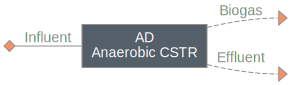

AnaerobicCSTR: AD
ins...
[0] Influent
phase: 'l', T: 308.15 K, P: 101325 Pa
flow (g/hr): S_su   70.8
                S_aa   7.08
                S_fa   7.08
                S_va   7.08
                S_bu   7.08
                S_pro  7.08
                S_ac   7.08
                S_h2   7.08e-05
                S_ch4  0.0708
                S_IC   3.4e+03
                S_IN   992
                S_I    142
                X_c    1.42e+04
                X_ch   3.54e+04
                X_pr   1.42e+05
                ...    6.97e+06
    WasteStream-specific properties:
     pH         : 7.0
     COD        : 57096.0 mg/L
     BOD        : 12769.4 mg/L
     TC         : 20596.5 mg/L
     TOC        : 20116.0 mg/L
     TN         : 3683.2 mg/L
     TP         : 489.3 mg/L
     TK         : 9.8 mg/L
outs...
[0] Biogas
phase: 'l', T: 298.15 K, P: 101325 Pa
flow: 0
    WasteStream-specific properties: None for empty waste streams
[1] Effluent
phase: 'l', T: 308.15 K, P: 101325 Pa
flow:

In [10]:
AD                                                             # anaerobic CSTR with influent, effluent, and biogas
                                                               # before running the simulation, 'outs' have nothing

In [11]:
# Set initial condition of the reactor
default_init_conds = {
    'S_su': 0.0124*1e3,
    'S_aa': 0.0055*1e3,
    'S_fa': 0.1074*1e3,
    'S_va': 0.0123*1e3,
    'S_bu': 0.0140*1e3,
    'S_pro': 0.0176*1e3,
    'S_ac': 0.0893*1e3,
    'S_h2': 2.5055e-7*1e3,
    'S_ch4': 0.0555*1e3,
    'S_IC': 0.0951*C_mw*1e3,
    'S_IN': 0.0945*N_mw*1e3,
    'S_I': 0.1309*1e3,
    'X_ch': 0.0205*1e3,
    'X_pr': 0.0842*1e3,
    'X_li': 0.0436*1e3,
    'X_su': 0.3122*1e3,
    'X_aa': 0.9317*1e3,
    'X_fa': 0.3384*1e3,
    'X_c4': 0.3258*1e3,
    'X_pro': 0.1011*1e3,
    'X_ac': 0.6772*1e3,
    'X_h2': 0.2848*1e3,
    'X_I': 17.2162*1e3
    }                                                           # concentration of each state variable in reactor

AD.set_init_conc(**default_init_conds)                          # set initial condition of AD

### 2.6. System set-up

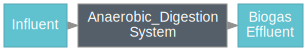

System: Anaerobic_Digestion
ins...
[0] Influent  
    phase: 'l', T: 308.15 K, P: 101325 Pa
    flow (kmol/hr): S_su   0.000393
                    S_aa   0.00708
                    S_fa   2.76e-05
                    S_va   6.94e-05
                    S_bu   8.13e-05
                    S_pro  9.69e-05
                    S_ac   0.00012
                    ...    709
outs...
[0] Biogas  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0
[1] Effluent  
    phase: 'l', T: 308.15 K, P: 101325 Pa
    flow: 0


In [12]:
# System
sys = System('Anaerobic_Digestion', path=(AD,))                 # aggregation of sanunits
sys.set_dynamic_tracker(eff, gas)                               # what you want to track changes in concentration
sys                                                             # before running the simulation, 'outs' have nothing

[Back to top](#top)

## 3. System Simulation <a class="anchor" id="s3"></a>

In [13]:
# Simulation settings
t = 10                          # total time for simulation
t_step = 0.1                    # times at which to store the computed solution              

method = 'BDF'                  # integration method to use
# method = 'RK45'
# method = 'RK23'
# method = 'DOP853'
# method = 'Radau'
# method = 'LSODA'

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html

In [14]:
# Run simulation
sys.simulate(state_reset_hook='reset_cache',
             t_span=(0,t),
             t_eval=np.arange(0, t+t_step, t_step),
             method=method,
            # export_state_to=f'sol_{t}d_{method}_AD.xlsx',               # uncomment to export simulation result as excel file
            )

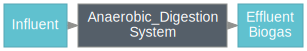

System: Anaerobic_Digestion
ins...
[0] Influent  
    phase: 'l', T: 308.15 K, P: 101325 Pa
    flow (kmol/hr): S_su   0.000393
                    S_aa   0.00708
                    S_fa   2.76e-05
                    S_va   6.94e-05
                    S_bu   8.13e-05
                    S_pro  9.69e-05
                    S_ac   0.00012
                    ...    709
outs...
[0] Biogas  
    phase: 'g', T: 308.15 K, P: 101325 Pa
    flow (kmol/hr): S_h2   0.00119
                    S_ch4  8.5
                    S_IC   0.414
                    H2O    0.205
[1] Effluent  
    phase: 'l', T: 308.15 K, P: 101325 Pa
    flow (kmol/hr): S_su   0.00164
                    S_aa   0.129
                    S_fa   0.0222
                    S_va   0.00332
                    S_bu   0.00447
                    S_pro  0.0106
                    S_ac   0.639
                    ...    587


In [15]:
sys                                                                      # now you have 'outs' info.

### 3.1. Check simulation results: Effluent

(<Figure size 800x450 with 1 Axes>,
 <Axes: xlabel='Time [d]', ylabel='Concentration [mg/L]'>)

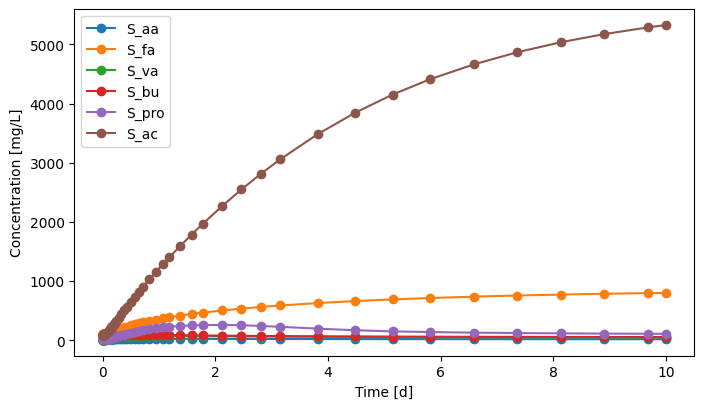

In [16]:
eff.scope.plot_time_series(('S_aa', 'S_fa', 'S_va', 'S_bu', 'S_pro', 'S_ac'))  # you can plot how each state variable changes over time

(<Figure size 800x450 with 1 Axes>,
 <Axes: xlabel='Time [d]', ylabel='Concentration [mg/L]'>)

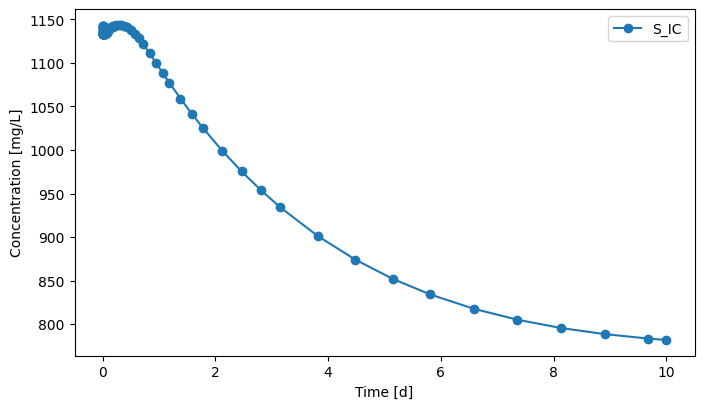

In [17]:
eff.scope.plot_time_series(('S_IC'))

(<Figure size 800x450 with 1 Axes>,
 <Axes: xlabel='Time [d]', ylabel='Concentration [mg/L]'>)

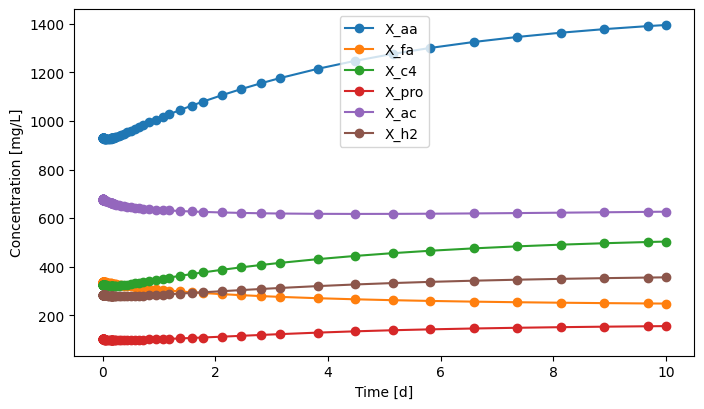

In [18]:
eff.scope.plot_time_series(('X_aa', 'X_fa', 'X_c4', 'X_pro', 'X_ac', 'X_h2'))

### 3.2. Check simulation results: Gas

(<Figure size 800x450 with 1 Axes>,
 <Axes: xlabel='Time [d]', ylabel='Concentration [mg/L]'>)

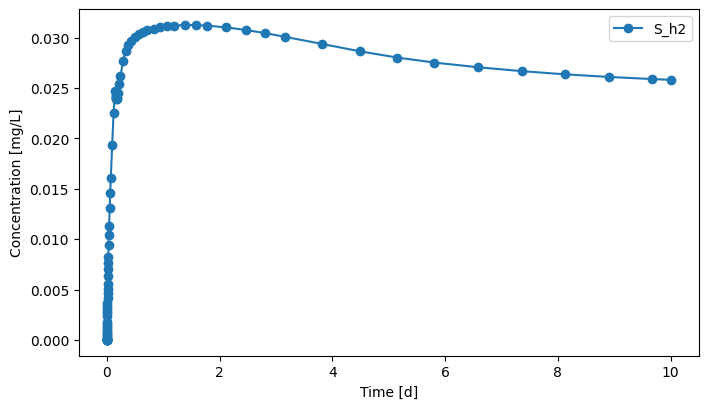

In [19]:
gas.scope.plot_time_series(('S_h2'))

(<Figure size 800x450 with 1 Axes>,
 <Axes: xlabel='Time [d]', ylabel='Concentration [mg/L]'>)

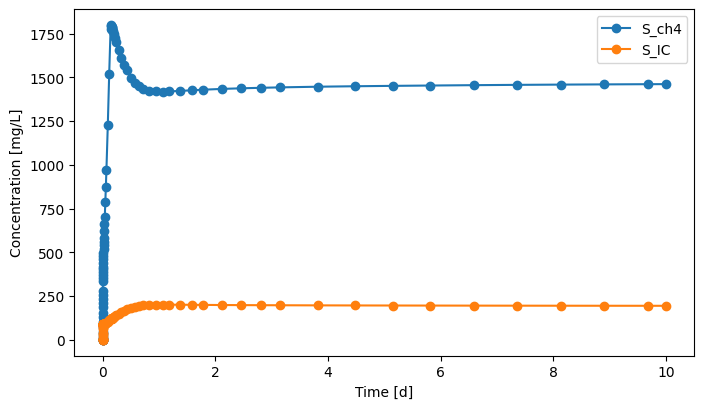

In [20]:
gas.scope.plot_time_series(('S_ch4','S_IC'))

### 3.3. Check simulation results: Total VFAs

In [21]:
# Total VFAs = 'S_va' + 'S_bu' + 'S_pro' + 'S_ac'    (you can change the equations based on your assumption)
idx_vfa = cmps.indices(['S_va', 'S_bu', 'S_pro', 'S_ac'])

t_stamp = eff.scope.time_series

vfa = eff.scope.record[:,idx_vfa]
total_vfa = np.sum(vfa, axis=1)

Text(0, 0.5, 'Total VFA [mg/l]')

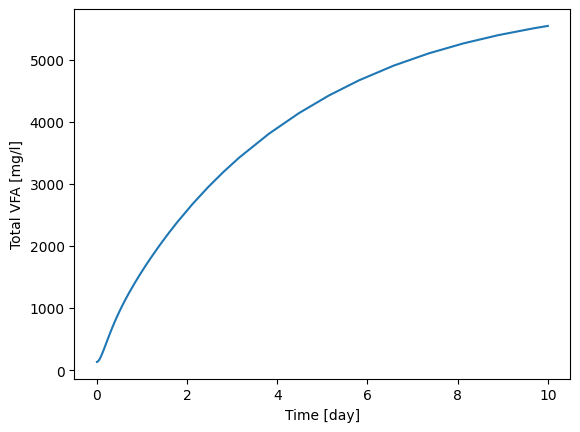

In [22]:
import matplotlib.pyplot as plt
plt.plot(t_stamp, total_vfa)
plt.xlabel("Time [day]")
plt.ylabel("Total VFA [mg/l]")